Multiple Regression on Matrices (MRM) analysis

dependent variable: beta-diversity

Intra-species sensitivity analysis: calculating MRM for permutations of samples within each species

In [1]:
setwd('/public/home/lyx/00.16S/00BR/00.bamboorat/phyloseq/')
list.files()

[1] "alpha_div.rds"                      "alpha_habitat.pdf"                 
 [3] "alpha_Observed_MRM.pdf"             "alpha_pgls.pdf"                    
 [5] "alpha_Shannon_MRM.pdf"              "alpha_species.pdf"                 
 [7] "ASV_species.xls"                    "ASV_table.tsv"                     
 [9] "beta_div.rds"                       "bray_distance.xls"                 
[11] "bray_MRM.pdf"                       "bray_pcoa.pdf"                     
[13] "bray_pgls.pdf"                      "dna-sequences.fasta"               
[15] "Enterotypes_bamboo.pdf"             "filtered-table.tsv"                
[17] "genus_lefse_Bathyergidae.pdf"       "genus_lefse_habitat.pdf"           
[19] "genus_lefse_Spalacidae.pdf"         "host_tree_exp_dist.RDS"            
[21] "host_tree_exp.nwk"                  "host_tree.nwk"                     
[23] "host_tree.pdf"                      "host_tree.png"                     
[25] "init.R"                             "metadata.txt"                      
[27] "otu_genus.xls"                      "otu_phylum.xls"                    
[29] "OTU_species.xls"                    "phyloseq_phylum_itol-phylumbar.txt"
[31] "phyloseq.rds"                       "physeq_diet-itol.txt"              
[33] "physeq_gut-itol.txt"                "physeq_life_style-itol.txt"        
[35] "physeq_sample_type-itol.txt"        "rarefied_ASV.xls"                  
[37] "rep.fa"                             "rep.xls"                           
[39] "rooted_tree.nwk"                    "taxa.xls"                          
[41] "taxonomy.tsv"                       "upgma_bray_species.pdf"

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(stringr)
library(phyloseq)
library(ecodist)
library(ggthemes)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘ecodist’


The following object is masked from ‘package:phyloseq’:

    distance




In [3]:
set.seed(8301)

Function

In [4]:
dist_mtx_order = function(d, x){
    # Ordering distance matrixes
    # d = distance matrix (dist class)
    # x = vector to order dist. obj. by
    m = d %>% as.matrix
    d = as.dist(m[x,x])
    return(d)
}

In [5]:
rescale_dist_mtx = function(m){
    m = m %>% as.matrix
    labs = m %>% colnames
    n_row = m %>% nrow
    n_col = m %>% ncol
    x = m %>% as.vector 
    x = scales::rescale(x) 
    m = matrix(x, nrow=n_row, ncol=n_col)
    colnames(m) = labs
    rownames(m) = labs
    m = m %>% as.dist
    return(m)
}

In [6]:
# load beta-div values
beta_div = readRDS("beta_div.rds")
# status
lapply(beta_div, function(x) x %>% as.vector %>% summary)

$jaccard
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3471  0.9936  0.9996  0.9619  1.0000  1.0000 

$bray
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2100  0.9873  0.9991  0.9417  1.0000  1.0000 

$unifrac
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1854  0.7063  0.7379  0.7131  0.7679  0.8830 

$wunifrac
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0197  0.2437  0.3348  0.3247  0.4385  0.5485 


In [7]:
phyloseq = readRDS("phyloseq.rds")
phyloseq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4858 taxa and 80 samples ]
sample_data() Sample Data:       [ 80 samples by 15 sample variables ]
tax_table()   Taxonomy Table:    [ 4858 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4858 tips and 4857 internal nodes ]

In [8]:
metadata = phyloseq %>%
    sample_data %>%
    as.matrix %>%
    as.data.frame %>%
    mutate(sampleid = rownames(.))

head(metadata)

,Sampleid,Group,Class,Order,Family,Genus,Species,Sample_type,Captive_Wild,Domestic_Wild,Habitat,Diet,Diet_detail,Digestive_tract,Digest_detail,sampleid
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
BMR1,BMR1,Spalacidae and relatives,Mammalia,Rodentia,Spalacidae,Spalax,Nannospalax leucodon,Feces,Wild,Wild,Underground,Herbivore,Herbivore,Hindgut fermentation,Cecum fermenter,BMR1
BMR2,BMR2,Spalacidae and relatives,Mammalia,Rodentia,Spalacidae,Spalax,Nannospalax leucodon,Feces,Wild,Wild,Underground,Herbivore,Herbivore,Hindgut fermentation,Cecum fermenter,BMR2
BMR3,BMR3,Spalacidae and relatives,Mammalia,Rodentia,Spalacidae,Spalax,Nannospalax leucodon,Feces,Wild,Wild,Underground,Herbivore,Herbivore,Hindgut fermentation,Cecum fermenter,BMR3
BMR4,BMR4,Spalacidae and relatives,Mammalia,Rodentia,Spalacidae,Spalax,Nannospalax leucodon,Feces,Wild,Wild,Underground,Herbivore,Herbivore,Hindgut fermentation,Cecum fermenter,BMR4
BMR5,BMR5,Spalacidae and relatives,Mammalia,Rodentia,Spalacidae,Spalax,Nannospalax leucodon,Feces,Wild,Wild,Underground,Herbivore,Herbivore,Hindgut fermentation,Cecum fermenter,BMR5
BMR6,BMR6,Spalacidae and relatives,Mammalia,Rodentia,Spalacidae,Spalax,Nannospalax leucodon,Feces,Wild,Wild,Underground,Herbivore,Herbivore,Hindgut fermentation,Cecum fermenter,BMR6


Host Phylogeny

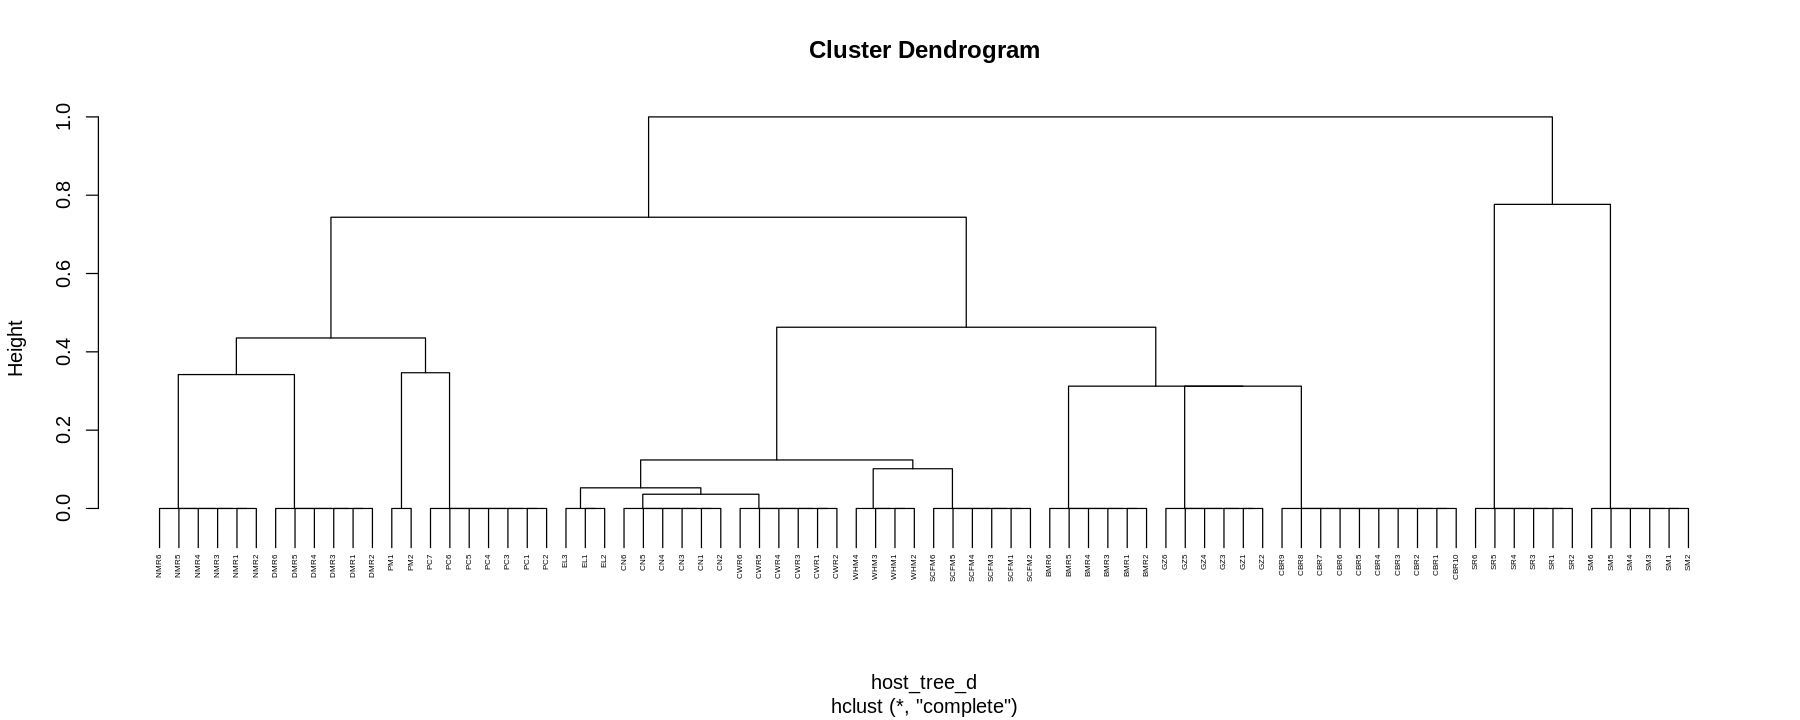

In [9]:
# patristic distance
host_tree_d = readRDS("host_tree_exp_dist.RDS")
options(repr.plot.height=6, repr.plot.width=15)
plot(hclust(host_tree_d), cex=0.4)

Distance matrics

Diet

In [10]:
diet=metadata %>%
    dplyr::select(Diet,Diet_detail) %>% 
    mutate(Diet=Diet %>% as.factor,Diet_detail=Diet_detail %>% as.factor) %>% 
    as.data.frame

head(diet)

,Diet,Diet_detail
,<fct>,<fct>
BMR1,Herbivore,Herbivore
BMR2,Herbivore,Herbivore
BMR3,Herbivore,Herbivore
BMR4,Herbivore,Herbivore
BMR5,Herbivore,Herbivore
BMR6,Herbivore,Herbivore


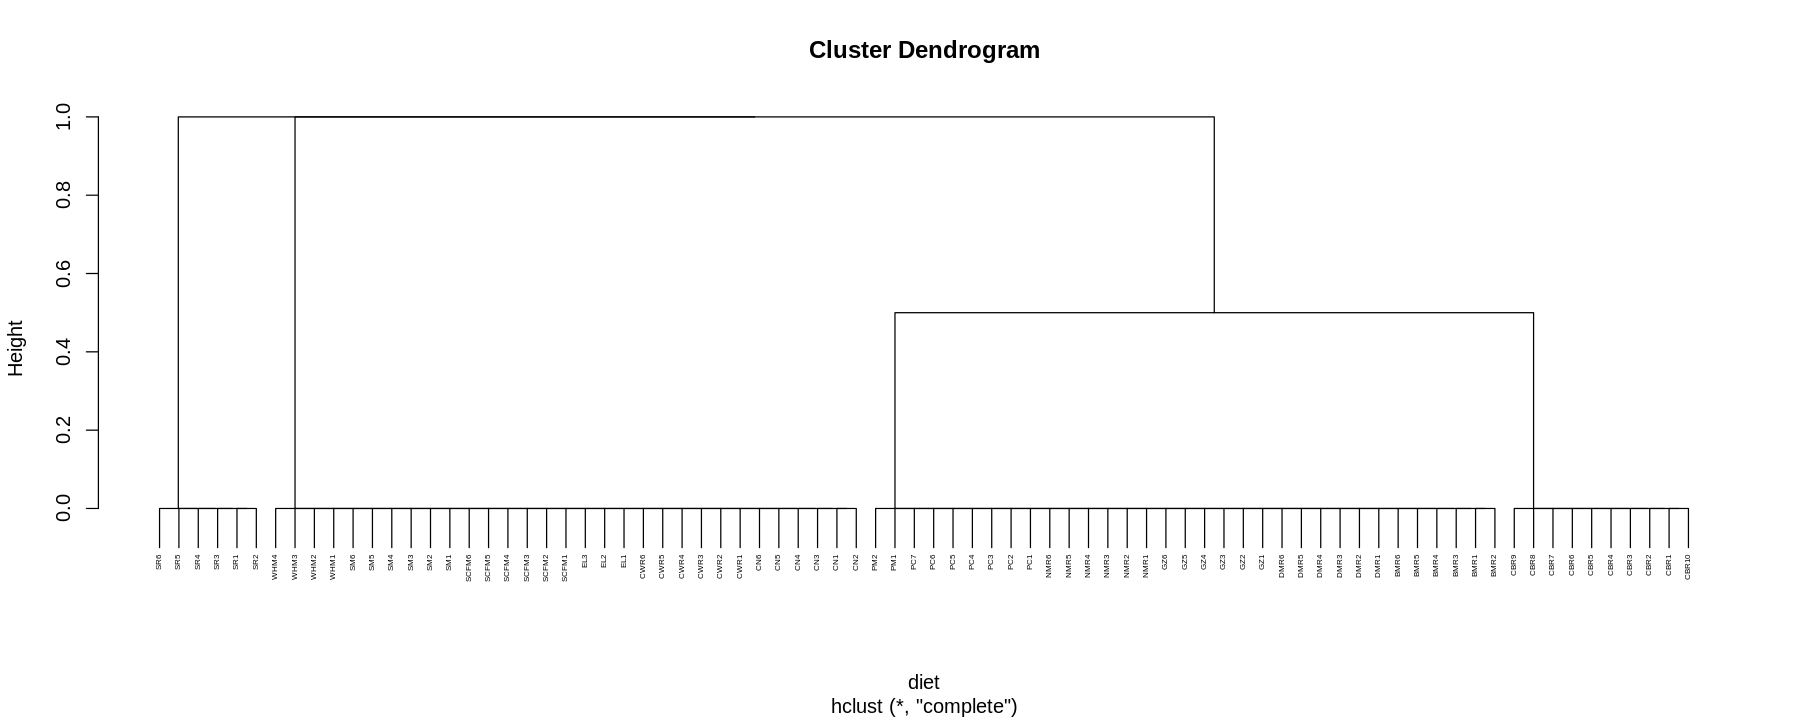

In [11]:
diet = cluster::daisy(diet, metric='gower')

options(repr.plot.height=6, repr.plot.width=15)
plot(hclust(diet), cex=0.4)

Digestive tract

In [12]:
dt= metadata %>%
    dplyr::select(Digestive_tract,Digest_detail) %>%
    mutate(Digestive_tract = Digestive_tract  %>% as.factor,Digest_detail = Digest_detail %>% as.factor) 

head(dt)

,Digestive_tract,Digest_detail
,<fct>,<fct>
BMR1,Hindgut fermentation,Cecum fermenter
BMR2,Hindgut fermentation,Cecum fermenter
BMR3,Hindgut fermentation,Cecum fermenter
BMR4,Hindgut fermentation,Cecum fermenter
BMR5,Hindgut fermentation,Cecum fermenter
BMR6,Hindgut fermentation,Cecum fermenter


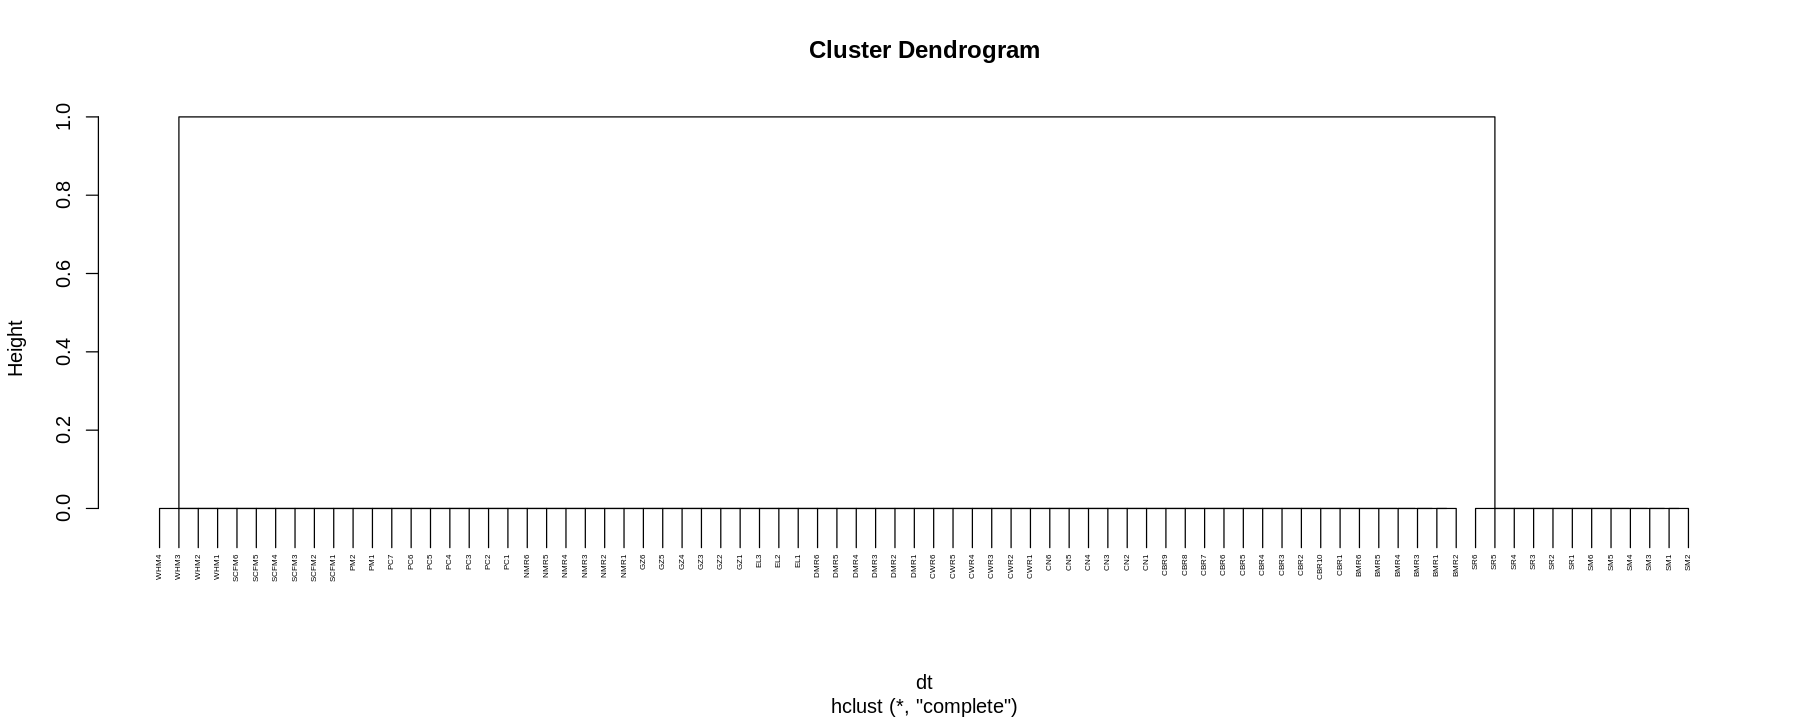

In [13]:
dt = cluster::daisy(dt, metric='gower')

options(repr.plot.height=6, repr.plot.width=15)
plot(hclust(dt), cex=0.4)

Technical method

In [14]:
tec = metadata %>%
    dplyr::select(Sample_type,Captive_Wild) %>% 
    mutate(Sample_type=Sample_type %>% as.factor,Captive_Wild = Captive_Wild %>% as.factor) %>% 
    as.data.frame
head(tec)

,Sample_type,Captive_Wild
,<fct>,<fct>
BMR1,Feces,Wild
BMR2,Feces,Wild
BMR3,Feces,Wild
BMR4,Feces,Wild
BMR5,Feces,Wild
BMR6,Feces,Wild


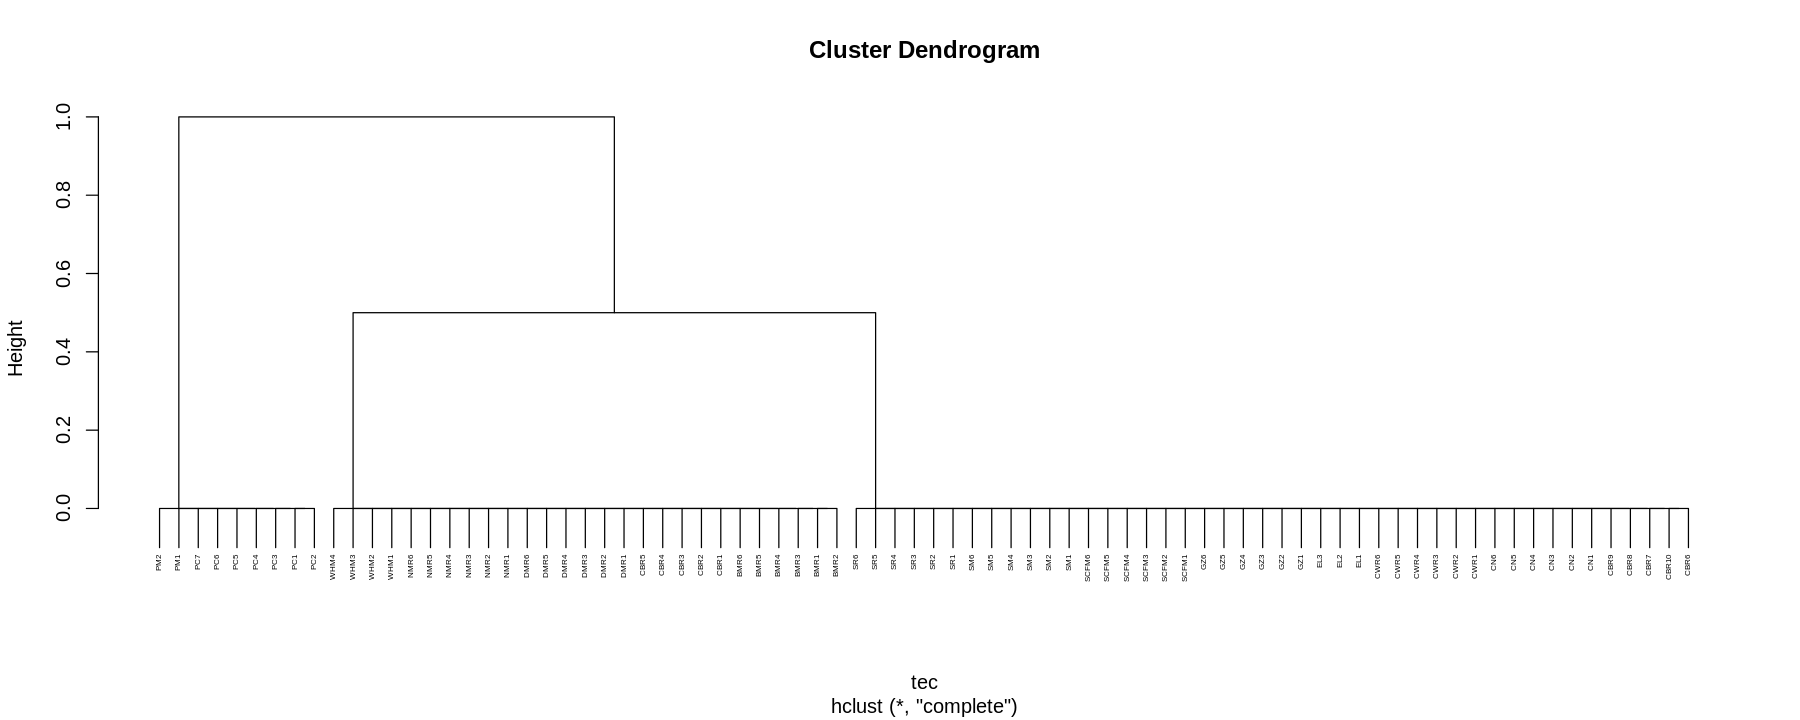

In [15]:
tec = cluster::daisy(tec, metric='gower')

options(repr.plot.height=6, repr.plot.width=15)
plot(hclust(tec), cex=0.4)

Habitat

In [16]:
ht = metadata %>%
    dplyr::select(Habitat) %>% 
    mutate(Habitat=Habitat %>% as.factor) %>% 
    as.data.frame
head(ht)

,Habitat
,<fct>
BMR1,Underground
BMR2,Underground
BMR3,Underground
BMR4,Underground
BMR5,Underground
BMR6,Underground


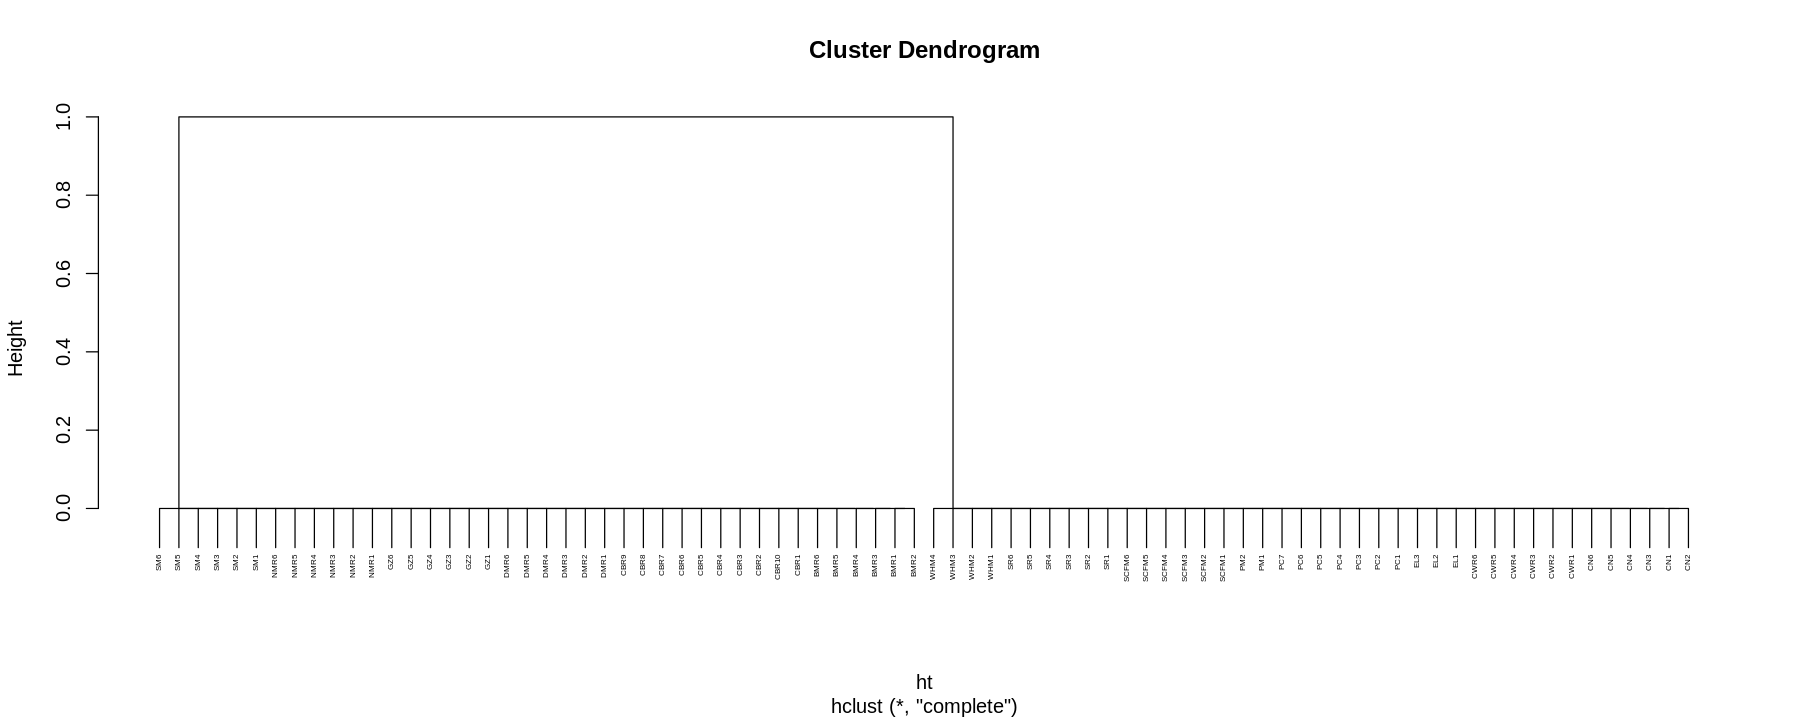

In [17]:
ht = cluster::daisy(ht, metric='gower')

options(repr.plot.height=6, repr.plot.width=15)
plot(hclust(ht), cex=0.4)

Ordering beta matrics

In [18]:
beta_div %>% labels

[1] "jaccard"  "bray"     "unifrac"  "wunifrac"

In [19]:
# ordering by beta-div metrix
X = labels(beta_div$unifrac)
host_tree_d_o = dist_mtx_order(host_tree_d, X)
diet_o = dist_mtx_order(diet, X)
tec_o = dist_mtx_order(tec, X)
dt_o = dist_mtx_order(dt, X)
ht_o = dist_mtx_order(ht, X)

In [20]:
# check
X %>% length %>% print
dt_o %>% labels %>% length %>% print

[1] 80
[1] 80


MRM intra-spec sensitivity

In [21]:
# number of permutated SpecD datasetst
nperm_datasets = 100
# number of permutations per MRM analysis
nperm = 1000

In [22]:
#' randomly selecting one per group
#' L : list of distance matrixes used for MRM
#' df_grps : data.frame (sample, group)
one_per_group = function(L, df_grps, ...){
    # get subsample
    colnames(df_grps) = c('Sample', 'Group')
    df_grps = df_grps %>%
        group_by(Group) %>%
        sample_n(2)
    # subsetting all matrices
    lapply(L, function(x) dist_mtx_order(x, df_grps$Sample))
}

In [23]:
#' MRM on one subsample rep
#' i : rep number
#' L : list of list of distance matrices generated by `one_per_group()`
# nperm : nperm function for MRM
# f : MRM fomulat
mrm_each = function(i, L, f, nperm=99){
    m = L[[i]]
    f = as.formula(f)
    x = ecodist::MRM(f, nperm=nperm, mrank=TRUE)
    # coefficients
    df = x$coef %>% as.data.frame
    colnames(df) = c('coef', 'coef_pval')
    df$variable = rownames(df)
    df$R2 = x$r.squared[1]
    df$pval = x$r.squared[2]
    df$F = x$F.test[1]
    df$rep = i
    return(df)
}

In [24]:
# renaming output
rename_df = data.frame(old_name = c('m$diet', 'm$digest', 'm$host_phy', 'm$tec', 'm$habitat'),
                       new_name = c('Diet', 'Digestive\nsystem', 'Phylogeny', 'Technical', 'Habitat'))

In [25]:
# grouping samples by species
df_grps = metadata %>% 
    filter(Sampleid %in% labels(diet_o)) %>%
    dplyr::select(Sampleid, Species)
head(df_grps)

,Sampleid,Species
,<chr>,<chr>
BMR1,BMR1,Nannospalax leucodon
BMR2,BMR2,Nannospalax leucodon
BMR3,BMR3,Nannospalax leucodon
BMR4,BMR4,Nannospalax leucodon
BMR5,BMR5,Nannospalax leucodon
BMR6,BMR6,Nannospalax leucodon


Unweighted unifrac

In [26]:
# creating multiple distance matrices
L = list(beta = beta_div$unifrac,
         host_phy = host_tree_d_o,
         diet = diet_o,
         digest = dt_o,
         habitat = ht_o,
         tec = tec_o)

m_perm = lapply(as.list(1:nperm_datasets), function(x) one_per_group(L, df_grps, x))
m_perm %>% length

[1] 100

In [25]:
# check on sample size
m_perm[[1]][[1]] %>% as.matrix %>% dim

[1] 46 46

Model

In [27]:
x = as.list(1:length(m_perm))
f = 'm$beta ~ m$host_phy + m$diet+ m$tec +m$digest +m$habitat'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm)
mrm_res = do.call(rbind, mrm_res)
head(mrm_res)

,coef,coef_pval,variable,R2,pval,F,rep
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
Int,86.53334692,0.999,Int,0.1944887,0.001,17.96369,1
m$host_phy,0.35405348,0.003,m$host_phy,0.1944887,0.001,17.96369,1
m$diet,0.21444890,0.005,m$diet,0.1944887,0.001,17.96369,1
m$tec,0.08887785,0.176,m$tec,0.1944887,0.001,17.96369,1
m$digest,-0.16950245,0.196,m$digest,0.1944887,0.001,17.96369,1
m$habitat,0.05548186,0.266,m$habitat,0.1944887,0.001,17.96369,1


In [28]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2              pval              rep        
 Min.   :0.1180   Min.   :0.00100   Min.   :  1.00  
 1st Qu.:0.1620   1st Qu.:0.00100   1st Qu.: 25.75  
 Median :0.1749   Median :0.00100   Median : 50.50  
 Mean   :0.1742   Mean   :0.00168   Mean   : 50.50  
 3rd Qu.:0.1872   3rd Qu.:0.00200   3rd Qu.: 75.25  
 Max.   :0.2295   Max.   :0.00900   Max.   :100.00  

,R2,pval,F,rep,category,value,variable
,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<chr>
1,0.1944887,0.001,17.96369,1,Coef.,0.35405348,Phylogeny
2,0.1944887,0.001,17.96369,1,Coef.,0.21444890,Diet
3,0.1944887,0.001,17.96369,1,Coef.,0.08887785,Technical
4,0.1944887,0.001,17.96369,1,Coef.,-0.16950245,Digestive system
5,0.1944887,0.001,17.96369,1,Coef.,0.05548186,Habitat
6,0.1813715,0.001,16.48371,2,Coef.,0.40716153,Phylogeny


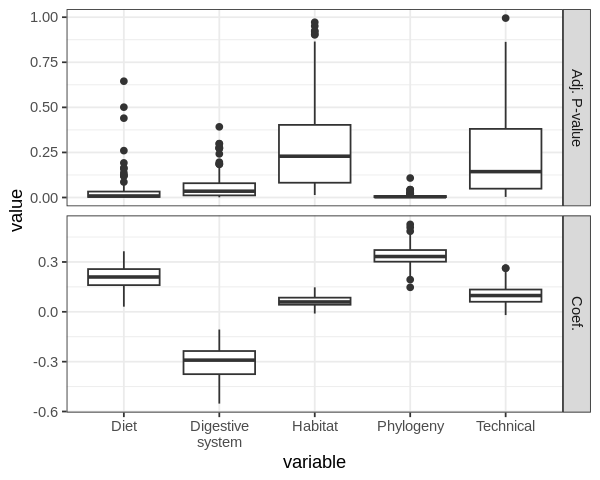

In [29]:
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)              
head(mrm_res_s)
# write.table(mrm_res_s,file = "MRM_beta_Unweighted_index.xls",sep="\t",row.names = T)
# changing coef scale
df = mrm_res_s %>%
    filter(category == 'Coef.') %>%
    mutate(value = 0.41) %>%
    .[1,]

# plotting
p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    geom_point(data=df, alpha=0) +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=4)
plot(p)

In [30]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval <= 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity <= 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
<chr>,<dbl>,<lgl>
Int,1.00,FALSE
m$diet,0.19,FALSE
m$digest,0.40,FALSE
m$habitat,0.85,FALSE
m$host_phy,0.01,TRUE
m$tec,0.74,FALSE


In [31]:
# R^2
mrm_res %>% 
    group_by(variable) %>%
    summarize(R2 =sum(R2) / length(R2)) %>%
    ungroup()

variable,R2
<chr>,<dbl>
Int,0.1742062
m$diet,0.1742062
m$digest,0.1742062
m$habitat,0.1742062
m$host_phy,0.1742062
m$tec,0.1742062


In [32]:
# pval
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval =sum(pval) / length(pval)) %>%
    ungroup()

variable,pval
<chr>,<dbl>
Int,0.00168
m$diet,0.00168
m$digest,0.00168
m$habitat,0.00168
m$host_phy,0.00168
m$tec,0.00168


Weighted unifrac

In [ ]:
# creating multiple distance matrices
L = list(beta = beta_div$wunifrac,
         host_phy = host_tree_d_o,
         diet = diet_o,
         digest = dt_o,
         habitat =habitat_o,
         tec = tec_o)

m_perm = lapply(as.list(1:nperm_datasets), function(x) one_per_group(L, df_grps, x))
m_perm %>% length

In [ ]:
x = as.list(1:length(m_perm))
f = 'm$beta ~ m$host_phy + m$diet+ m$tec +m$habitat +m$digest'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm)
mrm_res = do.call(rbind, mrm_res)
head(mrm_res)

In [ ]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

In [ ]:
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)              
head(mrm_res_s)
write.table(mrm_res_s,file = "MRM_beta_Weighted_index.xls",sep="\t",row.names = T)
# changing coef scale
df = mrm_res_s %>%
    filter(category == 'Coef.') %>%
    mutate(value = 0.41) %>%
    .[1,]

# plotting
p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    geom_point(data=df, alpha=0) +
    facet_grid(category ~ ., scales='free_y') +
    theme_few()

options(repr.plot.width=5, repr.plot.height=4)
plot(p)

In [ ]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval <= 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity <= 0.05)

In [ ]:
# R^2
mrm_res %>% 
    group_by(variable) %>%
    summarize(R2 =sum(R2) / length(R2)) %>%
    ungroup()

In [ ]:
# pval
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval =sum(pval) / length(pval)) %>%
    ungroup()

Bray Curtis

In [33]:
# creating multiple distance matrices
L = list(beta = beta_div$bray,
         host_phy = host_tree_d_o,
         diet = diet_o,
         digest = dt_o,
         habitat = ht_o,
         tec = tec_o)

m_perm = lapply(as.list(1:nperm_datasets), function(x) one_per_group(L, df_grps, x))
m_perm %>% length

[1] 100

In [34]:
x = as.list(1:length(m_perm))
f = 'm$beta ~ m$host_phy + m$diet + m$tec +m$digest +m$habitat'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm)
mrm_res = do.call(rbind, mrm_res)
head(mrm_res)

,coef,coef_pval,variable,R2,pval,F,rep
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
Int,133.06303353,0.930,Int,0.1997919,0.001,18.57581,1
m$host_phy,0.48114929,0.001,m$host_phy,0.1997919,0.001,18.57581,1
m$diet,0.19217118,0.011,m$diet,0.1997919,0.001,18.57581,1
m$tec,-0.02683021,0.667,m$tec,0.1997919,0.001,18.57581,1
m$digest,-0.44614907,0.003,m$digest,0.1997919,0.001,18.57581,1
m$habitat,0.09747921,0.058,m$habitat,0.1997919,0.001,18.57581,1


In [35]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2              pval              rep        
 Min.   :0.1753   Min.   :0.00100   Min.   :  1.00  
 1st Qu.:0.1943   1st Qu.:0.00100   1st Qu.: 25.75  
 Median :0.2028   Median :0.00100   Median : 50.50  
 Mean   :0.2032   Mean   :0.00111   Mean   : 50.50  
 3rd Qu.:0.2098   3rd Qu.:0.00100   3rd Qu.: 75.25  
 Max.   :0.2379   Max.   :0.00200   Max.   :100.00  

,R2,pval,F,rep,category,value,variable
,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<chr>
1,0.1997919,0.001,18.57581,1,Coef.,0.48114929,Phylogeny
2,0.1997919,0.001,18.57581,1,Coef.,0.19217118,Diet
3,0.1997919,0.001,18.57581,1,Coef.,-0.02683021,Technical
4,0.1997919,0.001,18.57581,1,Coef.,-0.44614907,Digestive system
5,0.1997919,0.001,18.57581,1,Coef.,0.09747921,Habitat
6,0.1981074,0.001,18.38050,2,Coef.,0.50191008,Phylogeny


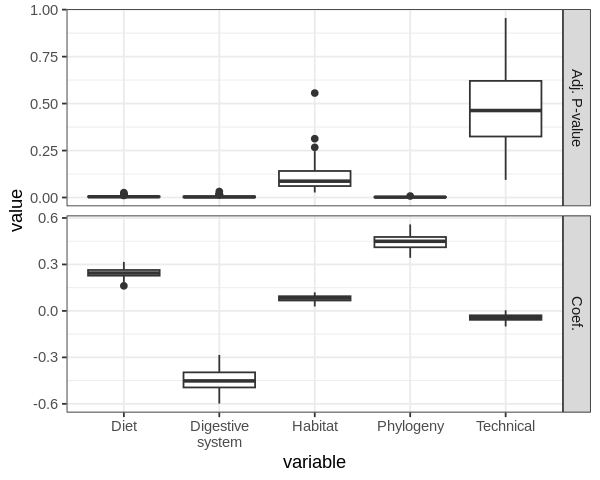

In [36]:
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)              
head(mrm_res_s)
# changing coef scale
df = mrm_res_s %>%
    filter(category == 'Coef.') %>%
    mutate(value = 0.41) %>%
    .[1,]

# plotting
p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    geom_point(data=df, alpha=0) +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=4)
plot(p)
ggsave("bray_MRM.pdf",width = 5,height = 4,dpi = 1000)

In [37]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval <= 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity <= 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
<chr>,<dbl>,<lgl>
Int,1.00,FALSE
m$diet,0.00,TRUE
m$digest,0.00,TRUE
m$habitat,0.85,FALSE
m$host_phy,0.00,TRUE
m$tec,1.00,FALSE


In [ ]:
# R^2
mrm_res %>% 
    group_by(variable) %>%
    summarize(R2 =sum(R2) / length(R2)) %>%
    ungroup()

In [ ]:
# pval
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval =sum(pval) / length(pval)) %>%
    ungroup()

Jaccard

In [ ]:
# creating multiple distance matrices
L = list(beta = beta_div$jaccard,
         host_phy = host_tree_d_o,
         diet = diet_o,
         digest = dt_o,
         habitat =habitat_o,
         tec = tec_o)

m_perm = lapply(as.list(1:nperm_datasets), function(x) one_per_group(L, df_grps, x))
m_perm %>% length

In [ ]:
x = as.list(1:length(m_perm))
f = 'm$beta ~ m$host_phy + m$diet + m$tec +m$habitat +m$digest'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm)
mrm_res = do.call(rbind, mrm_res)
head(mrm_res)

In [ ]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

In [ ]:
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)              
head(mrm_res_s)
write.table(mrm_res_s,file = "MRM_beta_Jaccard_index.xls",sep="\t",row.names = T)
# changing coef scale
df = mrm_res_s %>%
    filter(category == 'Coef.') %>%
    mutate(value = 0.41) %>%
    .[1,]

# plotting
p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    geom_point(data=df, alpha=0) +
    facet_grid(category ~ ., scales='free_y') +
    theme_few()

options(repr.plot.width=5, repr.plot.height=4)
plot(p)

In [ ]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval <= 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity <= 0.05)